# Customer Segmentation using Clustering

### Submitted by Jeff Hoffman
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [2]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

from jupyterthemes import jtplot
jtplot.style()

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [3]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

The first step is relatively simple. All we have to do is merge the df_offers and df_transactions datasets together.  We will do this using offer_id as the common variable.  

In [5]:
data = pd.merge(df_offers, df_transactions)
data.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


The next step is to use the pivot_table function to isolate the count of how many times each customer responded to a particular offer.  We will use customer_name as the index.

In [6]:
dataframe = data.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
dataframe.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
Allen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Bailey,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Baker,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


Inspecting the data, we see a lot of NaNs. We want to replace the NaNs with zero, which intuitively means that a customer did not repsond to an offer.

In [7]:
df_clean = dataframe.fillna(0).reset_index()
df_clean.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

 ####  What values of SS do you believe represent better clusterings? Why?
 
 There are two types of sum of squares to consider here.  One is the within clusters sum of squares (WSS) and the other is the between clusters sum of squares (BSS).  Smaller values of WSS indicate stronger internal cohesion among the clusterings.   Larger values of BSS represent stronger external separation between the clusterings. The total sum of squares (TSS) just adds the two together.  We want the ratio of BSS/TSS to approach 1 to achieve both internal cohesion and external separation. So, as BSS approaches TSS, WSS approaches zero.  However, we need to be aware of letting the number of clusters get too large, which would lead to overfitting.

#### Create a numpy matrix x_cols with only the columns representing the offers (i.e. the 0/1 columns)

In [8]:
x_cols = df_clean.drop(['customer_name'], axis=1)
x_cols.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Write code that applies the KMeans clustering method from scikit-learn to this matrix.

In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 5,
               init='k-means++',
               n_init=10,
               max_iter=300,
               tol=1e-04,
               random_state=123)
kmeans_result = kmeans.fit(x_cols)
distortion = kmeans_result.inertia_ # computes the within clusters sum of squares, or distortion of the model
print('Distortion: %.2f' % kmeans_result.inertia_)

Distortion: 205.28


#### Construct a plot showing  SS  for each  K  and pick  K  using this plot. For simplicity, test  2 ≤ K ≤ 10 .

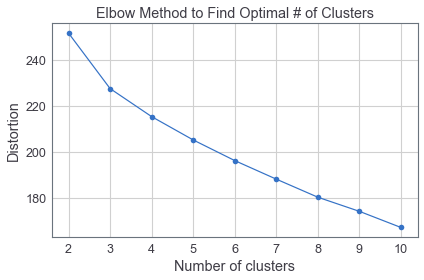

In [10]:
distortions = []
for i in range(2, 11):
    k_means = KMeans(n_clusters=i, 
                #init='k-means++', 
                #n_init=10, 
                #max_iter=300, 
                random_state=123)
    k_means.fit(x_cols)
    distortions.append(k_means.inertia_)
plt.plot(range(2, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method to Find Optimal # of Clusters')
plt.tight_layout()
#plt.savefig('images/11_03.png', dpi=300)
plt.show()

#### Make a bar chart showing the number of points in each cluster for k-means under the best K.

I will choose 5 as the optimal number of clusters from looking at the elbow plot above.  Because there is not a distinct elbow in the plot, it is hard to pick the optimal number of clusters using this method.  It looks like 4 or 6 clusters could work too, for example.

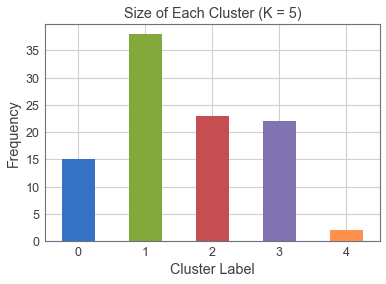

In [11]:
kmeans = KMeans(n_clusters = 5,
               init='k-means++',
               n_init=10,
               max_iter=300,
               tol=1e-04,
               random_state=123)
kmeans_result = kmeans.fit(x_cols)
pd.DataFrame(kmeans.labels_)[0].value_counts().sort_index().plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Cluster Label')
plt.ylabel('Frequency')
plt.title('Size of Each Cluster (K = 5)')
plt.show()

#### What challenges did you experience using the Elbow method to pick K?
There is not a clear location of where the elbow is located.  Let's investigate other methods to find out if we can add any more information to the decision of choosing the optimal number of clusters.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

#### Using the documentation of the silhouette_score function above, construct a series of slhouette plots like the ones in the article linked above.


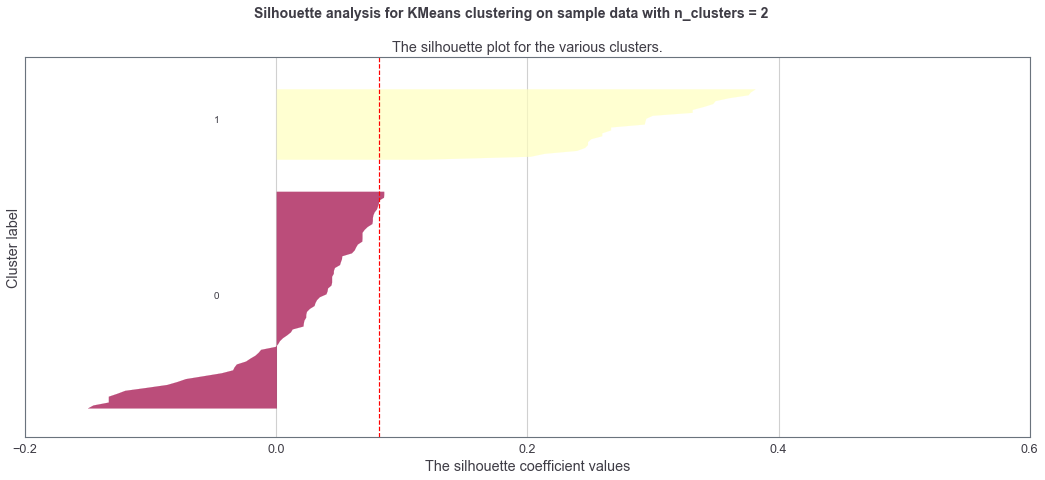

For n_clusters = 2 The average silhouette_score is : 0.08206113079944462


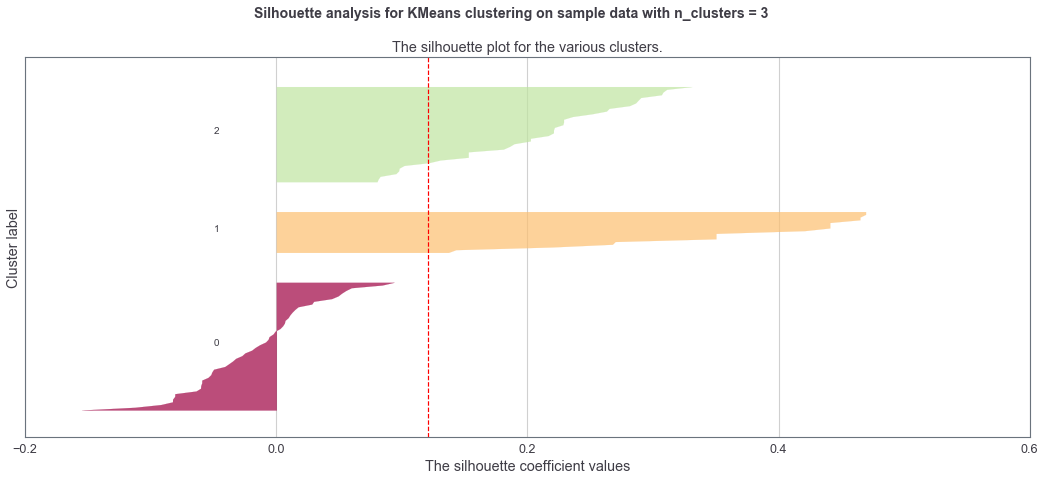

For n_clusters = 3 The average silhouette_score is : 0.12101628521627421


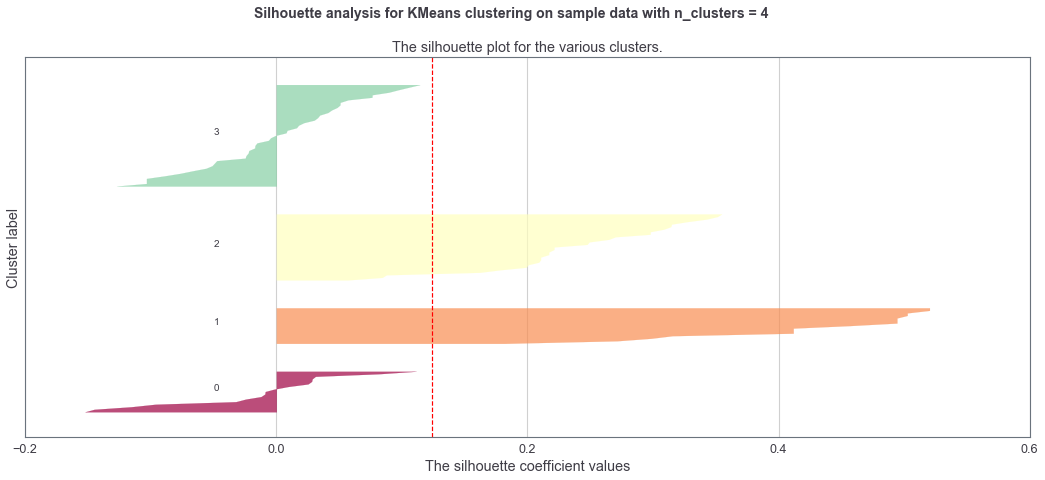

For n_clusters = 4 The average silhouette_score is : 0.12416494377606797


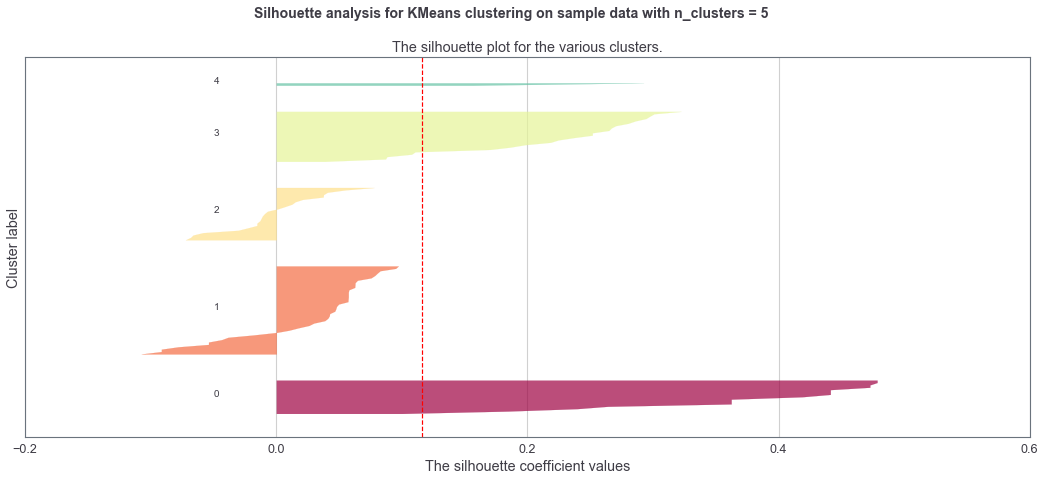

For n_clusters = 5 The average silhouette_score is : 0.11593800645322037


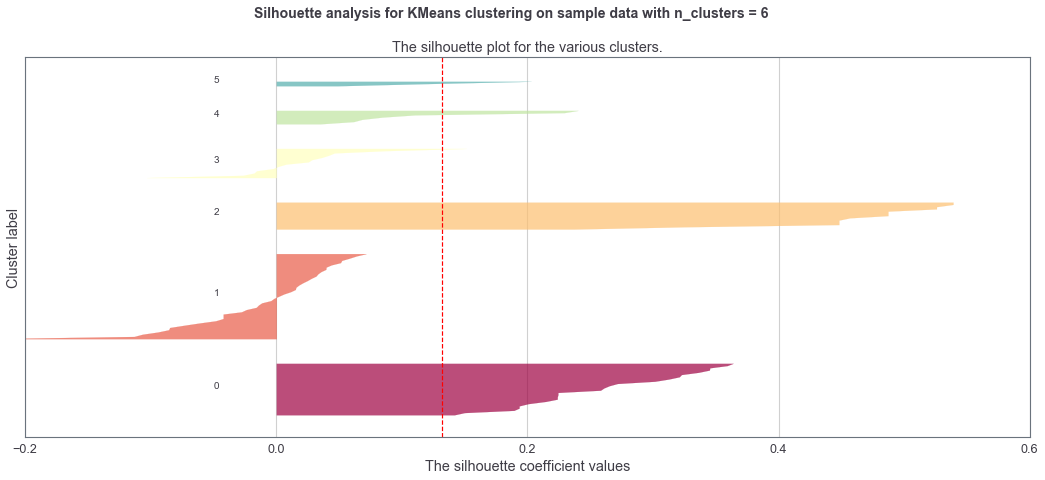

For n_clusters = 6 The average silhouette_score is : 0.1319407030176781


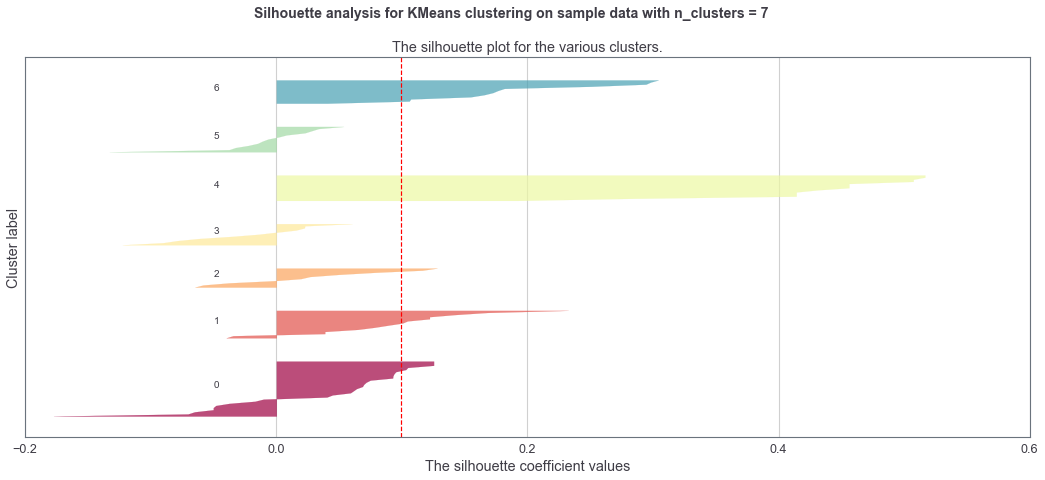

For n_clusters = 7 The average silhouette_score is : 0.09894629408384592


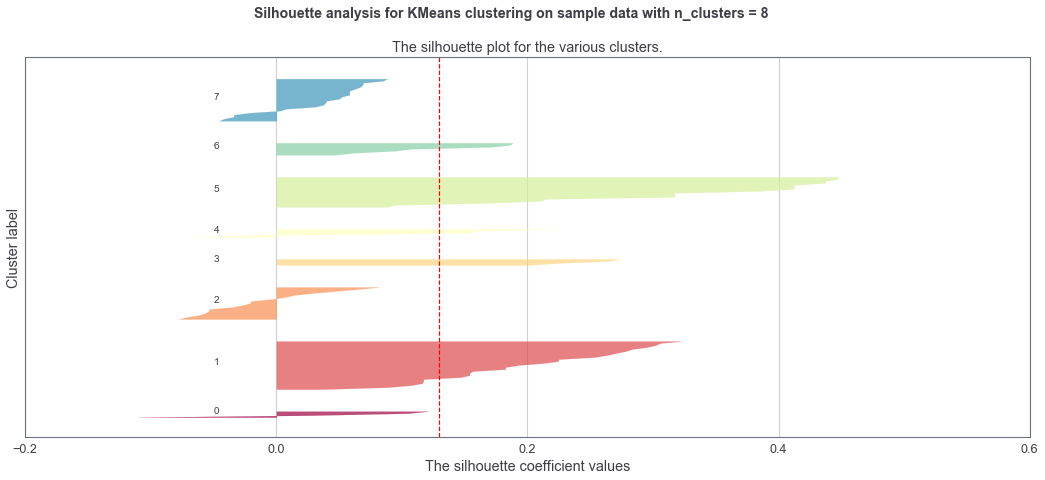

For n_clusters = 8 The average silhouette_score is : 0.12990584815609205


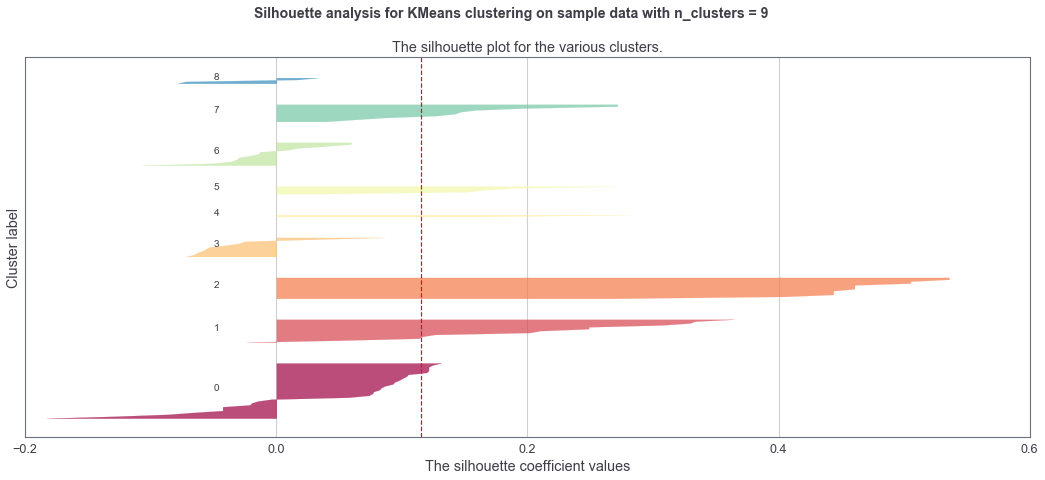

For n_clusters = 9 The average silhouette_score is : 0.11496043578541626


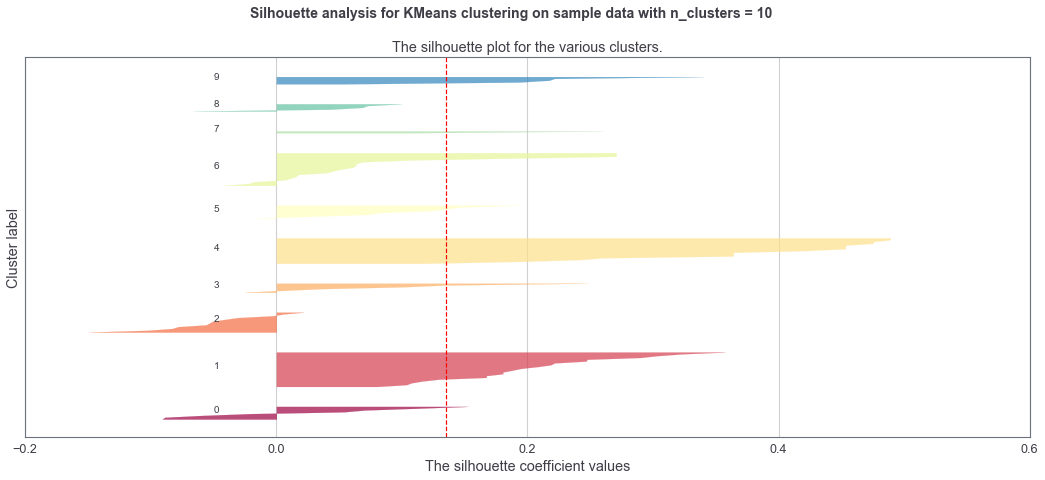

For n_clusters = 10 The average silhouette_score is : 0.13507870304456204


In [12]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2,3,4,5,6,7,8,9,10]
sil_values = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, .6])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, 
                       init='k-means++',
                       n_init=10, 
                       max_iter=300,
                       tol=1e-04,
                       random_state=123)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    sil_values.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6])

    

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

#### Compute the average silhouette score for each K and plot it. What K does the plot suggest we should choose? Does it differ from what we found using the Elbow method?

First off, it should be noted that all average silhouette scores indicate that there is poor clustering among customers.

From the plot below, we see that K=6 is the optimal number of clusters.  It does differ than we found from the elbow method, which was K=5 clusters.  There are also peaks in the plot below at K=8 and K=10 clusters.  At these higher values of K we should worry about overfitting, or how well the model would transfer to new data. Also, from a business or marketing perspective, developing characteristics for a smaller amount of clusters may lead to a more feasible and well-defined marketing campaign.

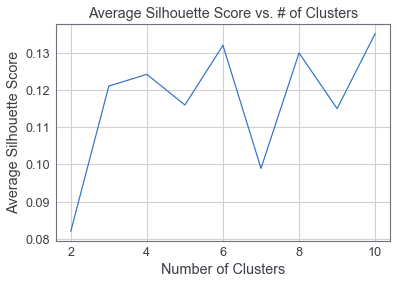

In [13]:
plt.plot(range(2,11), sil_values)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score vs. # of Clusters')
plt.show()

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

#### Use scikit-learn's PCA function to reduce the dimensionality of your clustering data to 2 components.


In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_cols)

#### Create a data frame with the following fields: customer name, cluster id the customer belongs to, the two PCA components (label them x an y)

In [15]:
kmeans = KMeans(n_clusters=3) # since we are working with poor clusters, let's choose K=3 so we can visualize the clusters easier. Maybe we can get some separation with the reduced dimensionality of the feature space..
kmeans_predict = kmeans.fit_predict(x_cols)

pc_df = pd.DataFrame(df_clean.customer_name)
pc_df['cluster_id'] = kmeans_predict
pc_df['x'] = X_pca[:,0]
pc_df['y'] = X_pca[:,1]
pc_df.head()

,customer_name,cluster_id,x,y
0,Adams,1,1.007580,0.108215
1,Allen,0,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,1,0.699477,-0.022542
4,Baker,0,0.088183,-0.471695


#### Plot a scatterplot of the x vs y columns

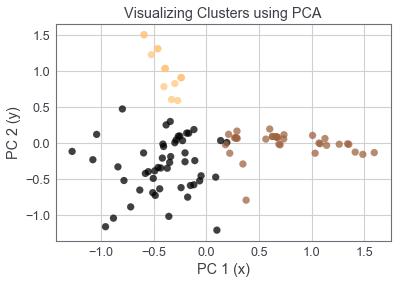

In [16]:
plt.scatter(pc_df.x, pc_df.y, marker='o', s=50, alpha=0.75, c=pc_df.cluster_id, cmap='copper')
plt.title("Visualizing Clusters using PCA")
plt.xlabel("PC 1 (x)")
plt.ylabel("PC 2 (y)")
#plt.style.context('fivethirtyeight')
plt.show()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

In [17]:
cluster_df = df_transactions.merge(pc_df, on='customer_name', right_index=True)
cluster_df = cluster_df.merge(df_offers, on='offer_id')
cluster_df.head()

,customer_name,offer_id,n,cluster_id,x,y,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,2,-0.300227,0.829765,January,Pinot Noir,72,17,France,False
1,Rodriguez,2,1,2,-0.403273,0.786296,January,Pinot Noir,72,17,France,False
2,Martin,2,1,0,-0.382241,0.254034,January,Pinot Noir,72,17,France,False
3,Jackson,2,1,0,-0.839578,-0.328823,January,Pinot Noir,72,17,France,False
4,Campbell,2,1,2,-0.522247,1.231406,January,Pinot Noir,72,17,France,False


In [18]:
cluster_df['is_2'] = cluster_df.cluster_id==2
cluster_df['is_1'] = cluster_df.cluster_id==1
cluster_df['is_0'] = cluster_df.cluster_id==0
print(cluster_df.groupby("is_2").campaign.value_counts(True))
print(cluster_df.groupby("is_2").varietal.value_counts(True))
print(cluster_df.groupby("is_2").min_qty.value_counts(True))
print(cluster_df.groupby("is_2").discount.value_counts(True))
print(cluster_df.groupby("is_2").origin.value_counts(True))
print(cluster_df.groupby("is_2").past_peak.value_counts(True))

is_2   campaign 
False  March        0.177700
       December     0.149826
       August       0.108014
       May          0.080139
       November     0.080139
       February     0.076655
       July         0.066202
       June         0.066202
       October      0.066202
       April        0.059233
       January      0.052265
       September    0.017422
True   September    0.324324
       October      0.297297
       July         0.189189
       January      0.135135
       June         0.027027
       May          0.027027
Name: campaign, dtype: float64
is_2   varietal          
False  Champagne             0.282230
       Prosecco              0.146341
       Espumante             0.139373
       Cabernet Sauvignon    0.111498
       Malbec                0.111498
       Merlot                0.066202
       Pinot Grigio          0.059233
       Chardonnay            0.052265
       Pinot Noir            0.031359
True   Pinot Noir            0.945946
       Merlot           

In [19]:
print(cluster_df.groupby("is_1").campaign.value_counts(True))
print(cluster_df.groupby("is_1").varietal.value_counts(True))
print(cluster_df.groupby("is_1").min_qty.value_counts(True))
print(cluster_df.groupby("is_1").discount.value_counts(True))
print(cluster_df.groupby("is_1").origin.value_counts(True))
print(cluster_df.groupby("is_1").past_peak.value_counts(True))

is_1   campaign 
False  October      0.127193
       August       0.122807
       December     0.118421
       February     0.087719
       January      0.087719
       June         0.087719
       March        0.074561
       May          0.074561
       September    0.074561
       April        0.065789
       July         0.052632
       November     0.026316
True   March        0.354167
       November     0.177083
       December     0.166667
       July         0.145833
       May          0.072917
       August       0.031250
       April        0.020833
       February     0.020833
       October      0.010417
Name: campaign, dtype: float64
is_1   varietal          
False  Champagne             0.333333
       Pinot Noir            0.192982
       Cabernet Sauvignon    0.135965
       Prosecco              0.100877
       Malbec                0.070175
       Chardonnay            0.065789
       Merlot                0.061404
       Espumante             0.035088
       Pinot 

In [20]:
print(cluster_df.groupby("is_0").campaign.value_counts(True))
print(cluster_df.groupby("is_0").varietal.value_counts(True))
print(cluster_df.groupby("is_0").min_qty.value_counts(True))
print(cluster_df.groupby("is_0").discount.value_counts(True))
print(cluster_df.groupby("is_0").origin.value_counts(True))
print(cluster_df.groupby("is_0").past_peak.value_counts(True))

is_0   campaign 
False  March        0.255639
       July         0.157895
       November     0.127820
       December     0.120301
       October      0.090226
       September    0.090226
       May          0.060150
       January      0.037594
       August       0.022556
       April        0.015038
       February     0.015038
       June         0.007519
True   August       0.146597
       December     0.141361
       February     0.104712
       June         0.099476
       October      0.094241
       March        0.089005
       May          0.083770
       April        0.078534
       January      0.078534
       November     0.031414
       July         0.026178
       September    0.026178
Name: campaign, dtype: float64
is_0   varietal          
False  Pinot Noir            0.263158
       Espumante             0.240602
       Prosecco              0.157895
       Malbec                0.120301
       Pinot Grigio          0.120301
       Merlot                0.052632
  

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

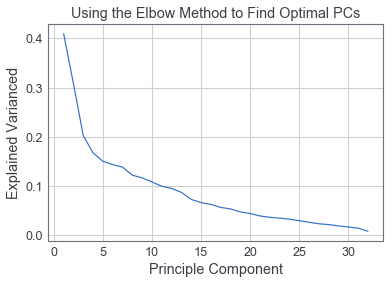

In [21]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
# Plot the explained variance by each component
plt.plot(range(1,33), pca.explained_variance_)
plt.xlabel('Principle Component')
plt.ylabel('Explained Varianced')
plt.title('Using the Elbow Method to Find Optimal PCs')
plt.show()

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


### My Response
***

### 1. Affinity Propogation

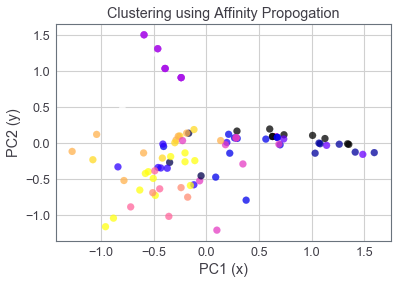

In [30]:
from sklearn.cluster import AffinityPropagation
ap = AffinityPropagation()
ap_fit = ap.fit_predict(x_cols)

plt.scatter(pc_df.x, pc_df.y, s=50, alpha=0.75, c=ap_fit, cmap='gnuplot2')
plt.title("Clustering using Affinity Propogation")
plt.xlabel("PC1 (x)")
plt.ylabel("PC2 (y)")
plt.show()

### 2. Spectral Clustering

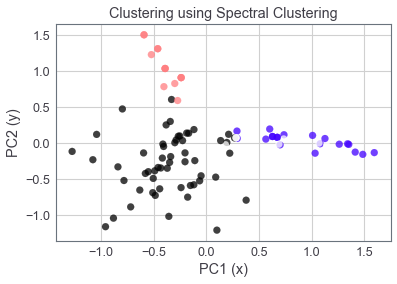

In [32]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=123)
sc_fit = sc.fit_predict(x_cols)

plt.scatter(pc_df.x, pc_df.y, s=50, alpha=0.75, c=sc_fit, cmap='gnuplot2')
plt.title("Clustering using Spectral Clustering")
plt.xlabel("PC1 (x)")
plt.ylabel("PC2 (y)")
plt.show()

### 3. Aglomerative Clustering

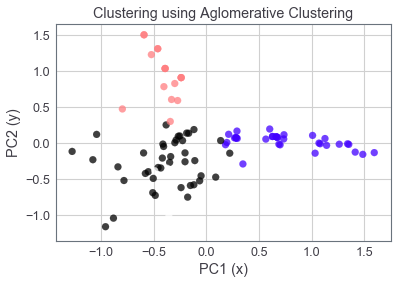

In [34]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=4, linkage='ward')
ac_fit = ac.fit_predict(x_cols)


plt.scatter(pc_df.x, pc_df.y, s=50, alpha=0.75, c=ac_fit, cmap='gnuplot2')
plt.title("Clustering using Aglomerative Clustering")
plt.xlabel("PC1 (x)")
plt.ylabel("PC2 (y)")
plt.show()

### 4. DBSCAN

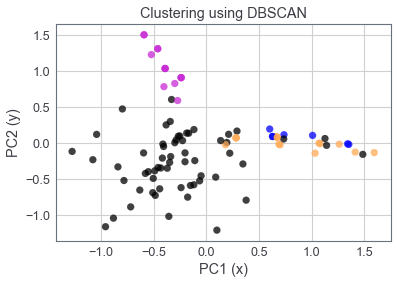

In [36]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=1.1)
db_fit = db.fit_predict(x_cols)

plt.scatter(pc_df.x, pc_df.y, s=50, alpha=0.75, c=db_fit, cmap='gnuplot2')
plt.title("Clustering using DBSCAN")
plt.xlabel("PC1 (x)")
plt.ylabel("PC2 (y)")
plt.show()